### 자전거 대여 수요 예측
- 데이터셋: kaggle bike-sharing-demand.csv
- 목적: 수요 예측
- 학습: 지도

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [2]:
DATA_PATH = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\bike_train.csv'

bikeDF = pd.read_csv(DATA_PATH)
print(bikeDF.shape)
bikeDF.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bikeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# 문자열을 datetime 타입으로 변경
bikeDF['datetime'] = bikeDF.datetime.apply(pd.to_datetime)

# datetime 타입에서 년,월,일,시간 추출
bikeDF['year'] = bikeDF.datetime.apply(lambda x:x.year)
bikeDF['month'] = bikeDF.datetime.apply(lambda x:x.month)
bikeDF['day'] = bikeDF.datetime.apply(lambda x:x.day)
bikeDF['hour'] = bikeDF.datetime.apply(lambda x:x.hour)
bikeDF.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
# casual(사전 등록 안한 사용자 대여 횟수) 
# + registered(사전 등록 안한 사용자 대여 횟수) =  count

drop_columns = ['datetime', 'casual','registered']
bikeDF.drop(drop_columns, axis=1, inplace=True)

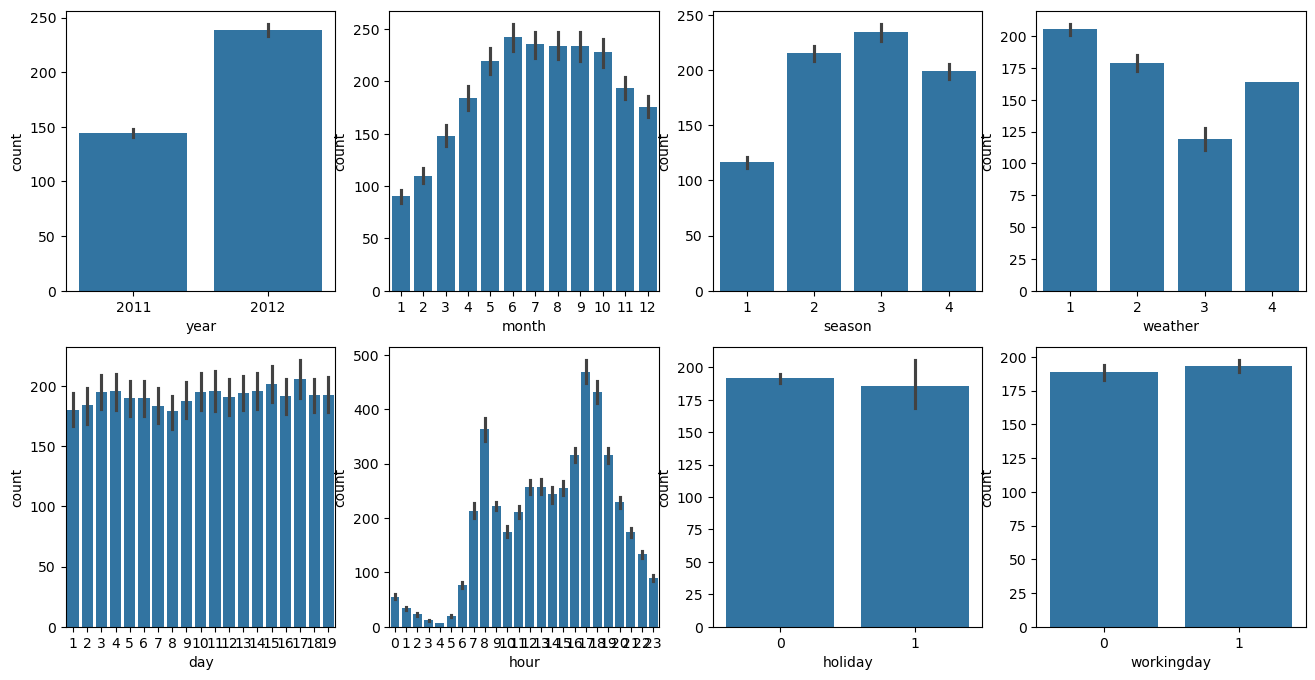

In [6]:
# 칼럼별 값에 따른 count 합 표현
# w/ barplot
fig, ax = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = i//4
    col = i%4
    
    sns.barplot(x=feature, y='count', data=bikeDF, ax=ax[row][col])


#### 다양한 회귀모델 데이터셋에 적용해 예측 성능 평가
- RMSLE (Root Mean Square Log Error)<br>
	- => sklearn 제공 X
	- => 직접 만들기 ^ㅁ^

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산

def rmsle(y, pred):
    
	## log1p(x) = log(1+x)		<=> expm1()로 원래 스케일 복원
    ## x=0이더라도 log(0)인 무한대 X!!
    ## 오버플로/언더플로 문제 해결!!
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    squared_error = (log_y-log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error() 이용해 rmsle 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))


# MAE, RMSE, RMSLE 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
	# MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))


#### 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 결과값의 정규분포 여부 확인
- 카테고리형 회귀 모델 => onehotEncoding

In [8]:
bikeDF.columns == 'count'

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False])

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bikeDF['count']
# X_features = bikeDF.drop(['count'], axis=1, inplace=True)
X_features = bikeDF.loc[:,~(bikeDF.columns=='count')].copy()
# print(y_target)
# print(X_features.head(3))


X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.3,
                                                    random_state=0
                                                    )
# 학습 모델 인스턴스 생성
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- 실제 count를 감안하면 예측오류로서 비교적 큰 값
- DF 칼럼으로 실제값-예측값 생성 & 오류값이 가장 큰 순 5개만 확인

In [10]:
def get_top_error_data(y_test, pred, n_tops=5):
    
	result_df = pd.DataFrame(y_test.values, columns=['real_count'])
	result_df['predicted_count'] = np.round(pred)

	result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

	print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 회귀에서 큰 예측 오류 발생시, 
target 분포가 왜곡된 형태인지 확인하기
- target의 분포는 '정규 분포' 형태가 가장 좋음

<Axes: >

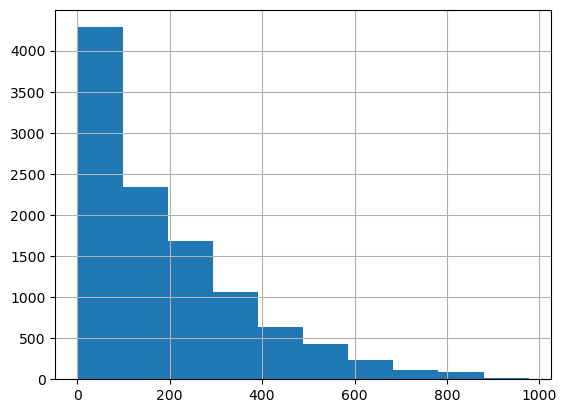

In [11]:
y_target.hist()

- 로그를 취해 정규 분포 형태로 변환
- log1p() (정규분포 변환) => 학습 => expm1(예측값)으로 원래 scale로 복구

<Axes: >

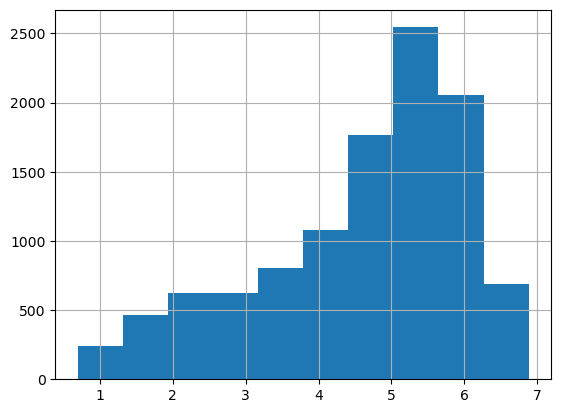

In [12]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [13]:
# 타깃 칼럼인 count를 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features,
                                                    y_target_log,
                                                    test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target=> 로그 변환 값
# expm1으로 원래 스케일 복구
y_test_exp = np.expm1(y_test)

# 예측값 또한 로그 변환된 타깃 기반으로 학습돼 예측된 값
# 다시 expm1으로 원래 스케일 복구
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSLE는 감소 & RMSE 증가
- 개별 피쳐들 인코딩 적용

<Axes: ylabel='None'>

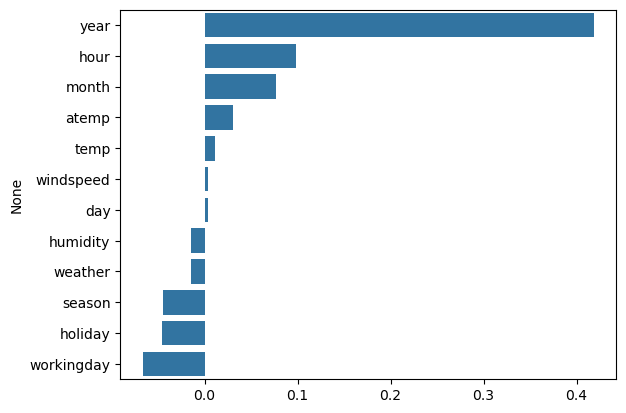

In [14]:
# 각 피쳐 회귀 계수 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)

sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year, hour, month => 카테고리형
- 숫자형 값에 영향 받지 않도록 원핫 인코딩 적용

In [15]:
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday',
                                                     'workingday','season','weather'])



In [16]:
# 원-핫 인코딩 적용된 피쳐 데이터셋으로
# 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                    test_size=0.3,
                                                    random_state=0
                                                    )

In [17]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    
	model.fit(X_train, y_train)
	pred = model.predict(X_test)

	# 로그로 정규 변환 필요 시
	if is_expm1:
		y_test = np.expm1(y_test)
		pred = np.expm1(pred)

	print('###', model.__class__.__name__, '###')
	evaluate_regr(y_test, pred)


	# end of func get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
rideg_reg = Ridge(alpha=10)			# 규제값 alpha
lasso_reg = Lasso(alpha=0.1)

for model in [lr_reg, rideg_reg, lasso_reg]:
	get_model_predict(model, X_train, X_test, y_train,y_test, is_expm1=True)



### LinearRegression ###
RMSLE: 0.590, RMSE: 97.690, MAE: 63.383
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 1.227, RMSE: 174.258, MAE: 119.504


<Axes: ylabel='None'>

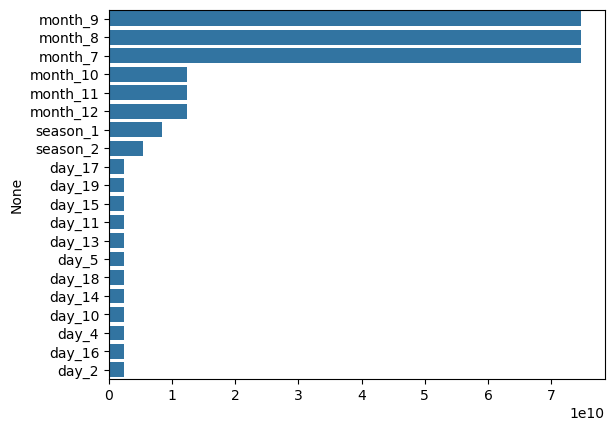

In [19]:
# 원-핫 인코딩 적용한 데이터셋에서 높은 회귀계수인 피쳐 시각화
# 상위 20개
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]

sns.barplot(x=coef_sort.values, y=coef_sort.index)
